In [87]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
import seaborn as sns
import matplotlib.pyplot as plt

In [70]:
def rhead(x, nrow = 6, ncol = 4):
    pd.set_option('display.expand_frame_repr', False)
    seq = np.arange(0, len(x.columns), ncol)
    for i in seq:
        print(x.loc[range(0, nrow), x.columns[
                range(i, min(i+ncol, len(x.columns)))]])
    pd.set_option('display.expand_frame_repr', True)

In [71]:
titanic_df = pd.read_csv('../Keras/titanic/train.csv')
titanic_test_df = pd.read_csv('../Keras/titanic/test.csv')
seed = 42

In [72]:
useless_cols = ['Name','PassengerId','Ticket']
titanic_df = titanic_df.drop(useless_cols, axis=1)
passengerIds_test = titanic_test_df[['PassengerId']]
titanic_test_df = titanic_test_df.drop(useless_cols, axis=1)

In [73]:
def clean_feature_columns(df, feature_columns):
    """ check if feature columns have any NaNs.
    Feature columns are used in groupby.
    They should not have any nans.
    """
    clean_cols = []
    for col in feature_columns:
        if df[col].isnull().any():
            continue
        else:
            clean_cols.append(col)
    return clean_cols

def fill_numeric_col(df, feature_columns, target_column):
    """
    We fill the numeric columns by median. 
    
    feature_columns : list. This will create group-by sub-indexes. The order
    will be as it appears in the list. If a particular sub-index results in
    median value of NaN, it is automatically dropped from feature_columns
    
    target_column: the target column that is to be filled
    """
    filled_col_name = target_column + '_filled'
    if df[target_column].isnull().any():
        df[filled_col_name] = df.groupby(feature_columns)[target_column]\
            .transform(lambda x: x.fillna(np.nan if pd.isnull(x.median()) else x.median()))
        while True:
            if df[filled_col_name].isnull().any():
                if len(feature_columns) > 1:
                    del feature_columns[-1]
                    df[filled_col_name] = df.groupby(feature_columns)[filled_col_name]\
            .transform(lambda x: x.fillna(np.nan if pd.isnull(x.median()) else x.median()))
                else:
                    df[filled_col_name] = df[filled_col_name].fillna(df[target_column].median(dropna=True))
                    break
            else:
                break
        return df
    else:
        df[filled_col_name] = df[target_column]
        return df

def fill_categoric_col(df, feature_columns, target_column):
    """
    We fill the categorical columns by mode. 
    
    feature_columns : list. This will create group-by sub-indexes. The order
    will be as it appears in the list. If a particular sub-index results in
    mode value of NaN, it is automatically dropped from feature_columns
    
    target_column: the target column that is to be filled
    """
    filled_col_name = target_column + '_filled'
    if df[target_column].isnull().any():
        df[filled_col_name] = df.groupby(feature_columns)[target_column]\
            .transform(lambda x: x.fillna(np.nan if x.count()<=0 else x.mode()[0]))
        while True:
            if df[filled_col_name].isnull().any():
                if len(feature_columns) > 1:
                    del feature_columns[-1]
                    df[filled_col_name] = df.groupby(feature_columns)[filled_col_name]\
            .transform(lambda x: x.fillna(np.nan if x.count()<=0 else x.mode()[0]))
                else:
                    df[filled_col_name] = df[filled_col_name].fillna(df[target_column].mode(dropna=True))
                    break
            else:
                break
        return df
    else:
        df[filled_col_name] = df[target_column]
        return df

In [74]:
titanic_train_df = fill_numeric_col(titanic_df,clean_feature_columns(
    titanic_df,['Sex', 'Pclass','Parch']),'Age')
titanic__train_df = fill_categoric_col(
    titanic_df,clean_feature_columns(titanic_df,['Sex', 'Pclass','Parch','SibSp']),'Embarked')
titanic__train_df = fill_categoric_col(
    titanic_df,clean_feature_columns(titanic_df,['Sex', 'Pclass','Parch','SibSp']),'Cabin')

In [75]:
titanic_test_df = fill_numeric_col(titanic_test_df,clean_feature_columns(
    titanic_test_df,['Sex', 'Pclass','Parch']),'Age')
titanic_test_df = fill_numeric_col(titanic_test_df,clean_feature_columns(
    titanic_test_df,['Sex', 'Pclass','Parch']),'Fare')
titanic_test_df = fill_categoric_col(
    titanic_test_df,clean_feature_columns(titanic_test_df,['Sex', 'Pclass','Parch','SibSp']),'Embarked')
titanic_test_df = fill_categoric_col(
    titanic_test_df,clean_feature_columns(titanic_test_df,['Sex', 'Pclass','Parch','SibSp']),'Cabin')

In [76]:
titanic_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
Survived           891 non-null int64
Pclass             891 non-null int64
Sex                891 non-null object
Age                714 non-null float64
SibSp              891 non-null int64
Parch              891 non-null int64
Fare               891 non-null float64
Cabin              204 non-null object
Embarked           889 non-null object
Age_filled         891 non-null float64
Embarked_filled    891 non-null object
Cabin_filled       891 non-null object
dtypes: float64(3), int64(4), object(5)
memory usage: 83.6+ KB


In [77]:
titanic_train_df = titanic_train_df.drop(columns=['Age','Embarked','Cabin'])
titanic_train_df = titanic_train_df.rename(
    {'Age_filled': 'Age', 'Embarked_filled': 'Embarked', 'Cabin_filled': 'Cabin'},
    axis='columns')
# axis=columns is equivalent to axis=1

In [78]:
titanic_test_df = titanic_test_df.drop(columns=['Age','Embarked','Cabin','Fare'])
titanic_test_df = titanic_test_df.rename(
    {'Age_filled': 'Age', 'Embarked_filled': 'Embarked', 'Cabin_filled': 'Cabin', 'Fare_filled': 'Fare'},
    axis='columns')

In [79]:
titanic_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
Survived    891 non-null int64
Pclass      891 non-null int64
Sex         891 non-null object
SibSp       891 non-null int64
Parch       891 non-null int64
Fare        891 non-null float64
Age         891 non-null float64
Embarked    891 non-null object
Cabin       891 non-null object
dtypes: float64(2), int64(4), object(3)
memory usage: 62.7+ KB


In [80]:
titanic_test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 8 columns):
Pclass      418 non-null int64
Sex         418 non-null object
SibSp       418 non-null int64
Parch       418 non-null int64
Age         418 non-null float64
Fare        418 non-null float64
Embarked    418 non-null object
Cabin       418 non-null object
dtypes: float64(2), int64(3), object(3)
memory usage: 26.2+ KB


In [121]:
y = titanic_train_df[['Survived']]
X = titanic_train_df.drop(['Survived'], axis=1)
#X = pd.get_dummies(X, columns=['Sex','Pclass','Cabin','Embarked'])

#titanic_test = pd.get_dummies(titanic_test_df, columns=['Sex','Pclass','Cabin','Embarked'])

In [122]:
print(X.shape)
print(titanic_test_df.shape)

(891, 8)
(418, 8)


In [123]:
from sklearn.ensemble import RandomForestClassifier

In [124]:
#print(X.columns.tolist())
#print(titanic_test_df.columns.tolist())
titanic_test_df = titanic_test_df.reindex(columns=X.columns.tolist())
joined = pd.concat([X,titanic_test_df])
joined =  pd.get_dummies(joined, columns=['Sex','Pclass','Cabin','Embarked'])
X = joined_dummies.iloc[0:891,:]
titanic_test = joined_dummies.iloc[891:,:]

In [126]:
print(X.shape)
print(titanic_test.shape)

(891, 198)
(418, 198)


/home/helios/anaconda3/envs/tensorflow_env/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/helios/anaconda3/envs/tensorflow_env/lib/python3.6/site-packages/sklearn/ensemble/forest.py:463: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/home/helios/anaconda3/envs/tensorflow_env/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/helios/anaconda3/envs/tensorflow_env/lib/python3.6/site-packages/sklearn/ensemble/forest.py:463: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/home/helios/anaconda3/envs/

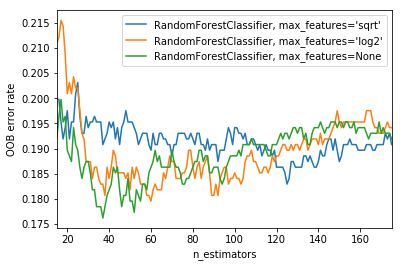

In [127]:
# https://scikit-learn.org/stable/auto_examples/ensemble/plot_ensemble_oob.html
from collections import OrderedDict

y = y.values.ravel()

RANDOM_STATE = 0
ensemble_clfs = [
    ("RandomForestClassifier, max_features='sqrt'",
        RandomForestClassifier(n_estimators=100,
                               warm_start=True, oob_score=True,
                               max_features="sqrt",
                               random_state=RANDOM_STATE)),
    ("RandomForestClassifier, max_features='log2'",
        RandomForestClassifier(n_estimators=100,
                               warm_start=True, max_features='log2',
                               oob_score=True,
                               random_state=RANDOM_STATE)),
    ("RandomForestClassifier, max_features=None",
        RandomForestClassifier(n_estimators=100,
                               warm_start=True, max_features=None,
                               oob_score=True,
                               random_state=RANDOM_STATE))
]

# Map a classifier name to a list of (<n_estimators>, <error rate>) pairs.
error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)

# Range of `n_estimators` values to explore.
min_estimators = 15
max_estimators = 175

for label, clf in ensemble_clfs:
    for i in range(min_estimators, max_estimators + 1):
        clf.set_params(n_estimators=i)
        clf.fit(X, y)

        # Record the OOB error for each `n_estimators=i` setting.
        oob_error = 1 - clf.oob_score_
        error_rate[label].append((i, oob_error))

# Generate the "OOB error rate" vs. "n_estimators" plot.
for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    plt.plot(xs, ys, label=label)

plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.legend(loc="upper right")
plt.show()

In [152]:
clf = RandomForestClassifier(n_estimators=35, max_features=None,random_state=0,n_jobs=3)

In [153]:
#y_pred = clf.predict(titanic_test)
X_train,X_test,y_train,y_test = train_test_split(X,
                                                 y,
                                                 test_size=0.20,
                                                 random_state=RANDOM_STATE)
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

In [154]:
from sklearn.metrics import accuracy_score,recall_score,confusion_matrix

In [155]:
#y_pred.shape
print(accuracy_score(y_test,y_pred))
print(recall_score(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))

0.8379888268156425
0.7246376811594203
[[100  10]
 [ 19  50]]


In [136]:
titanic_test_df.head()

,Pclass,Sex,SibSp,Parch,Fare,Age,Embarked,Cabin
0,3,male,0,0,7.8292,34.5,Q,F E46
1,3,female,1,0,7.0000,47.0,S,G6
2,2,male,0,0,9.6875,62.0,Q,D
3,3,male,0,0,8.6625,27.0,S,F E46
4,3,female,1,1,12.2875,22.0,S,G6
